# Show contributions to ComBind Score in a Heiracrchical Fashion

In [24]:
import sys
import os
import numpy as np
sys.path.append('../1_dock')
sys.path.append('../ifp')
sys.path.append('../mcss')
sys.path.append('../3_analyze')
from density_estimate import DensityEstimate
from prob_opt import PredictStructs
from statistics import statistics
from containers import Dataset
from shared_paths import shared_paths

shared_paths['data'] = '/Users/jpaggi/Documents/combind/combind_data/bpp_data'

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Read settings
def read_settings(root):
    tr = {}
    with open('{}/settings.py'.format(root)) as f:
        for line in f:
            var,val = line.split('=')
            tr[var] = eval(val)
    return tr

def read_score_file(fname):
    """
    Returns a dictionary of {lig_name: pose, ...} stored
    in FNAME.
    """
    combind_cluster, best_cluster = {}, {}
    with open(fname) as fp:
        fp.readline()
        for line in fp:
            tok = line.strip().split(',')
            if len(tok) != 3:
                combind_cluster[tok[0]] = int(tok[1])
                best_cluster[tok[0]] = int(tok[5])
    return combind_cluster, best_cluster
            
def read_data(protein, shared_paths, pose_cluster):
    cwd = os.getcwd()
    data = Dataset(shared_paths, [protein])
    data.load({protein: list(set([lig for lig in pose_cluster]))},
              load_mcss = True, load_fp = True)
    os.chdir(cwd)
    return data

def read_stats(root, features):
    stats = {}
    for dist in ['native', 'reference']:
        stats[dist] = {}
        for feature in features:
            stats[dist][feature] = DensityEstimate.read('{}/{}_{}.txt'.format(root, dist, feature))
    return stats

def read_ps(root, score_file, protein):
    settings = read_settings(root)
     
    combind_cluster, best_cluster = read_score_file(score_file)
    data = read_data(protein, shared_paths, combind_cluster)
    stats = read_stats(root, settings['k_list'])
    ps = PredictStructs(data.proteins[protein], stats, settings['k_list'], 100, settings['t'])
    
    l_list = sorted(combind_cluster.keys())
    combind_top = ps.get_poses(combind_cluster)
    glide_top   = ps.get_poses({l:0 for l in combind_cluster})
    best_top    = ps.get_poses(best_cluster)
    return ps, l_list, combind_top, glide_top, best_top

In [26]:
feature_defs = {
    'hbond_donor':[2],
    'hbond_acceptor': [3],
    'sb2':[1],
    'pipi':[6],
    'contact':[11]
}


proteins = [fname for fname in os.listdir('../../combind_data/bpp_data/') if fname[0] != '.']
scores = '/pdb_seperated_hbond_pipi'
cluster_file = 'pdb.sc'

In [27]:
protein = 'B2AR'
root = '{}/{}/scores/{}'.format(shared_paths['data'], protein, scores)
score_file = "{}/{}".format(root, cluster_file)
ps, l_list, features, combind_top, glide_top, best_top = read_ps(root, score_file, protein)

# Examine Single Pose Cluster

In [78]:
poses = combind_top
cluster = {ligand: pose.rank for ligand, pose in poses.items()}

def interaction_contributions(poses, cluster, ps):
    scores = {}
    for k in ps.k_list:
        x, logp = ps.likelihood_and_feature_matrix(cluster, k, l_list)
        scores[k] = logp.sum()
    scores['gscore'] = -sum(pose.gscore for pose in poses.values()) / ps.T
    assert abs(sum(scores.values()) - ps.log_posterior(cluster)) < 0.001
    return scores

def marginal_contributions(poses, cluster, ps, ligand):
    scores = {}
    for k in ps.k_list:
        x, logp = ps.likelihood_and_feature_matrix(cluster, k, l_list)
        scores[k] = logp[l_list.index(ligand), :].sum() + logp[:, l_list.index(ligand)].sum()
    scores['gscore'] = -poses[ligand].gscore / ps.T
    return scores

def residue_features(poses, cluster, ps, feature, ligand1, ligand2):
    assert ligand1 < ligand2
    scores = {}
    lp = ps.lig_pairs[(ligand1, ligand2)]
    _, norm = lp.feat_map[feature]
    for res in set(poses[ligand1].fp.keys()).intersection(poses[ligand2].fp.keys()):
        if res[0] in feature_defs[feature]:
            scores[res[1]] = (poses[ligand1].fp[res], poses[ligand2].fp[res])
    return norm, scores
        
print marginal_contributions(poses, cluster, ps, poses.keys()[0])
print interaction_contributions(poses, cluster, ps)
print residue_features(poses, cluster, ps, 'hbond_donor', poses.keys()[0], poses.keys()[1])

{'sb2': 9.8655795833449176, 'mcss': 1.6868792296387976, 'hbond_acceptor': 7.8317012808150182, 'gscore': 61.08, 'contact': 3.7201921324299496, 'hbond_donor': 9.711312286135076, 'pipi': 2.3903721821001342}
{'sb2': 34.529528541707208, 'mcss': 0.090315263641519206, 'hbond_acceptor': 26.375135589380008, 'gscore': 339.72, 'contact': 3.9611819439829894, 'hbond_donor': 32.9191793782866, 'pipi': 9.7012767734811458}
(1.0, {'A:312(ASN)': (1.0, 1.0)})


# Comparing Two Pose Clusters

In [58]:
poses1 = combind_top
cluster1 = {ligand: pose.rank for ligand, pose in poses1.items()}
poses2 = glide_top
cluster2 = {ligand: pose.rank for ligand, pose in poses2.items()}

scores1 = interaction_contributions(poses1, cluster1, ps)
scores2 = interaction_contributions(poses2, cluster2, ps)

for k in scores1:
    print k, scores2[k] - scores1[k]

sb2 0.0
mcss -5.94856251925
hbond_acceptor -0.862347538269
gscore 8.04
contact -16.8872453409
hbond_donor -18.8490989305
pipi -12.5567504457


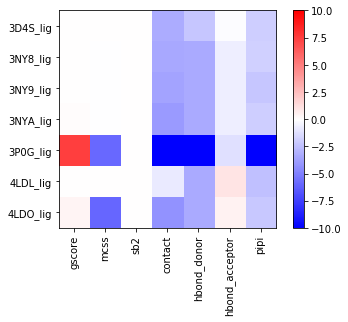

In [74]:
X = []
for ligand in l_list:
    X += [[]]
    scores1 = marginal_contributions(poses1, cluster1, ps, ligand)
    scores2 = marginal_contributions(poses2, cluster2, ps, ligand)
    X[-1] += [scores2['gscore'] - scores1['gscore']]
    for k in ps.k_list:
        X[-1] += [scores2[k] - scores1[k]]
        
sc = plt.imshow(X, vmin = -10, vmax = 10, cmap = 'bwr')
plt.colorbar(sc)
plt.xticks(range(len(ps.k_list)+1), ['gscore'] + ps.k_list, rotation = 'vertical')
plt.yticks(range(len(l_list)), l_list)
plt.show()

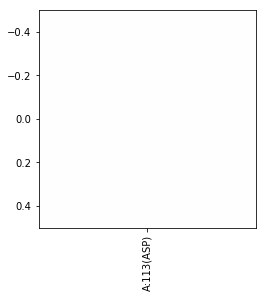

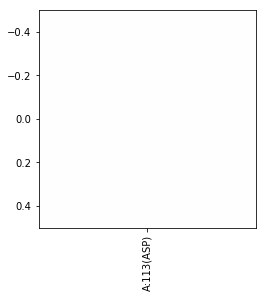

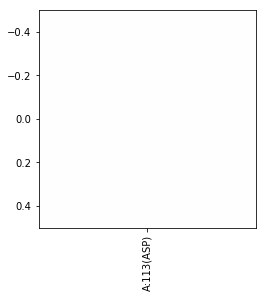

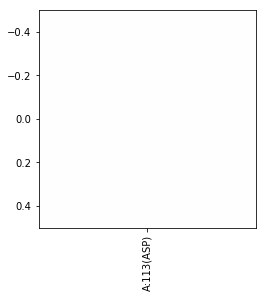

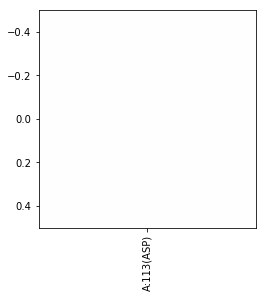

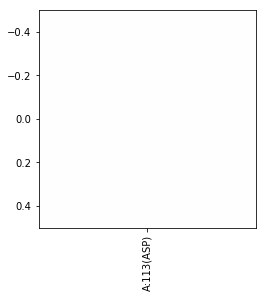

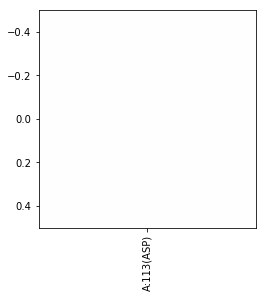

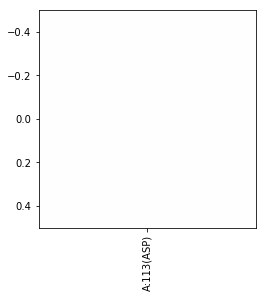

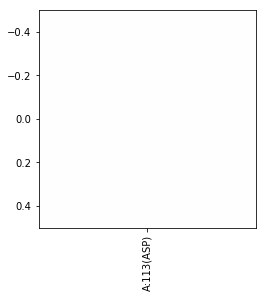

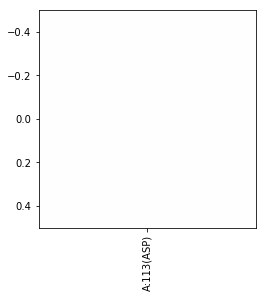

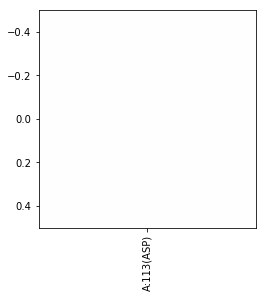

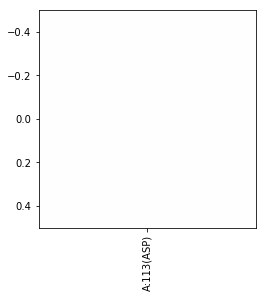

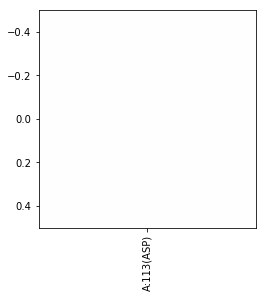

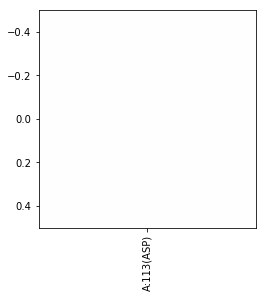

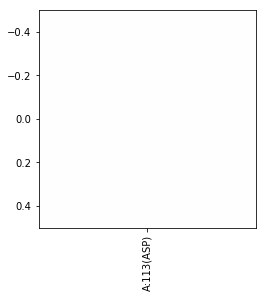

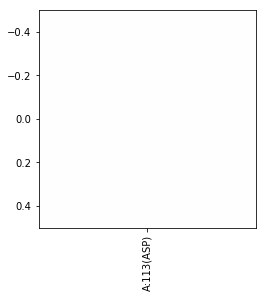

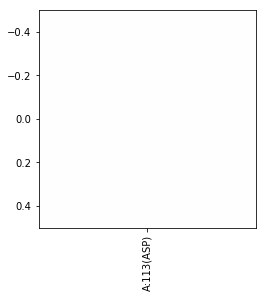

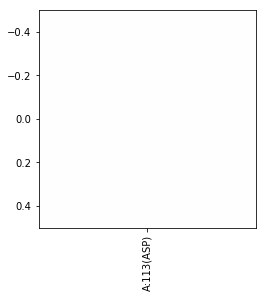

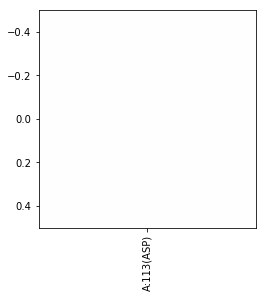

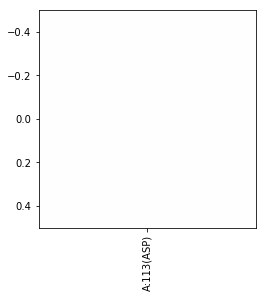

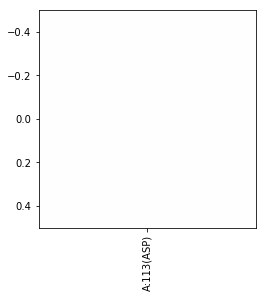

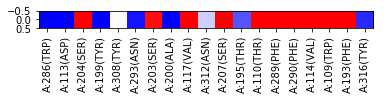

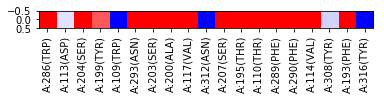

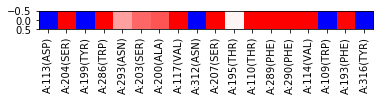

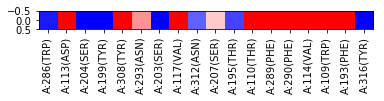

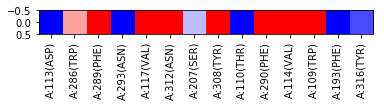

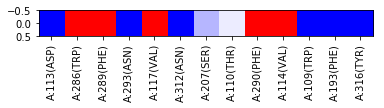

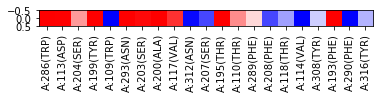

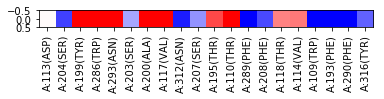

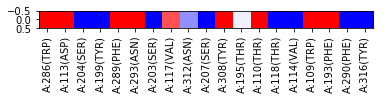

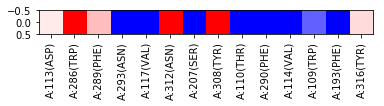

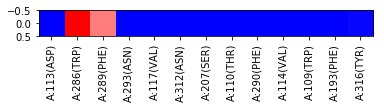

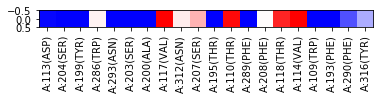

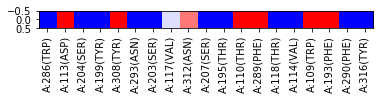

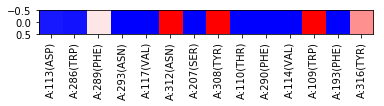

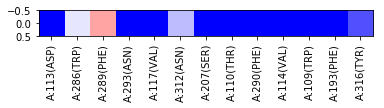

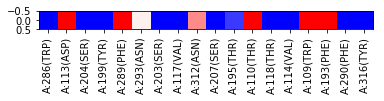

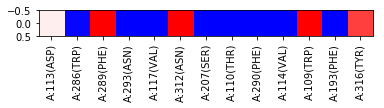

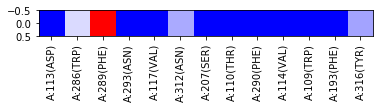

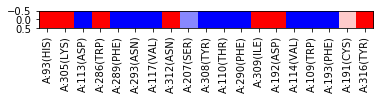

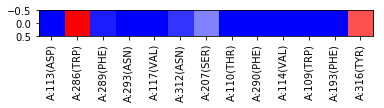

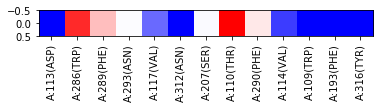

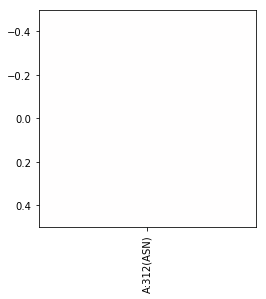

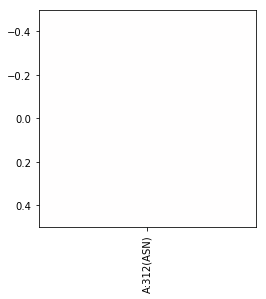

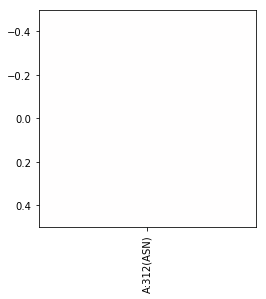

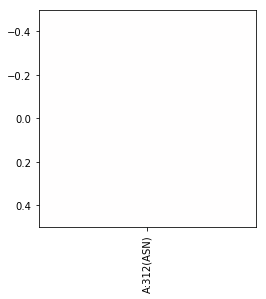

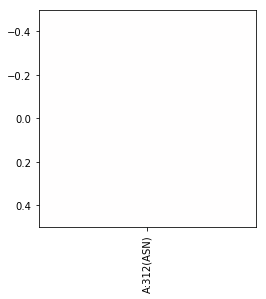

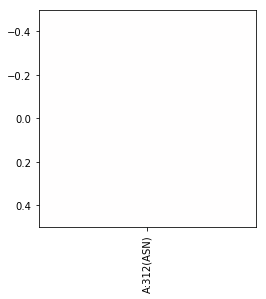

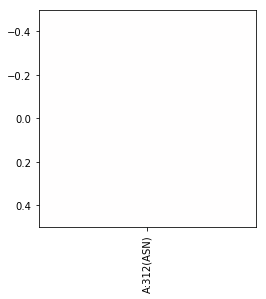

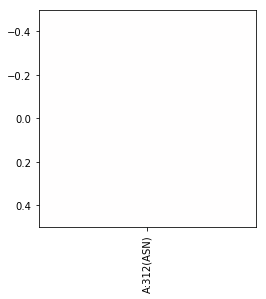

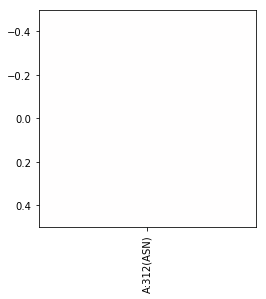

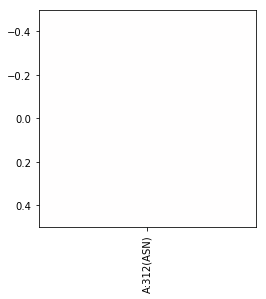

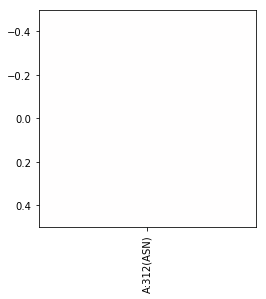

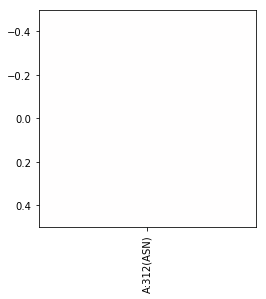

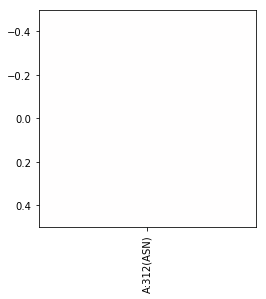

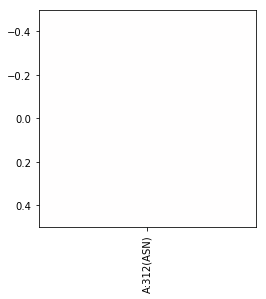

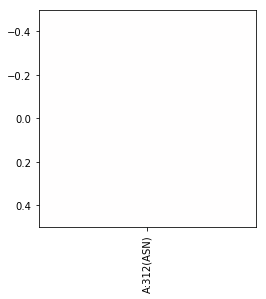

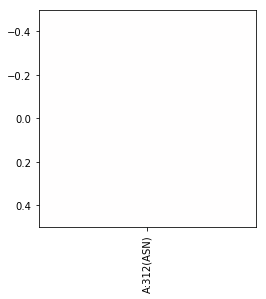

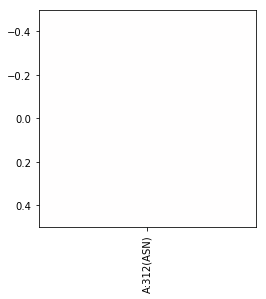

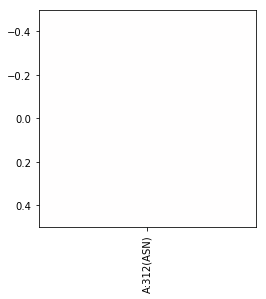

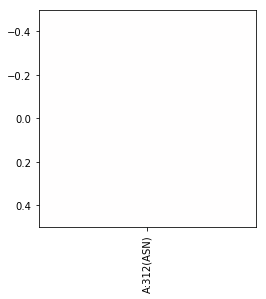

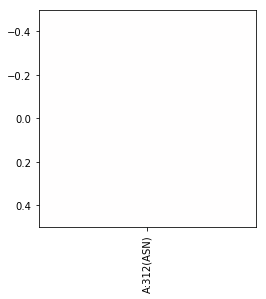

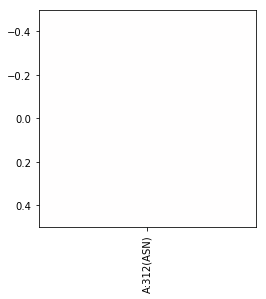

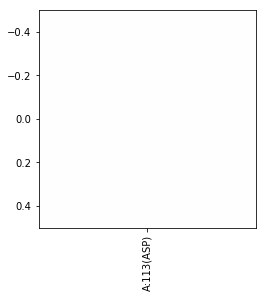

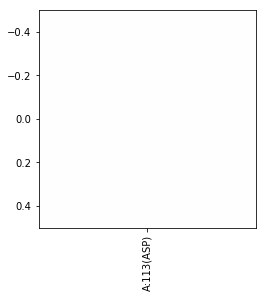

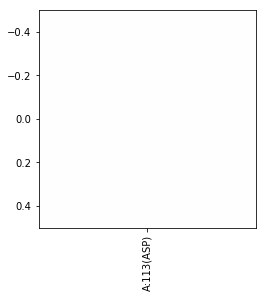

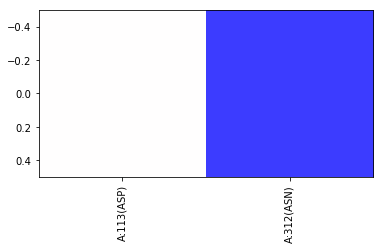

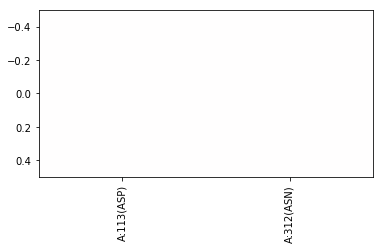

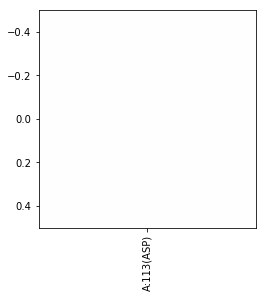

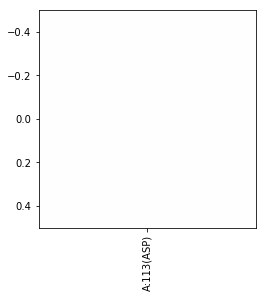

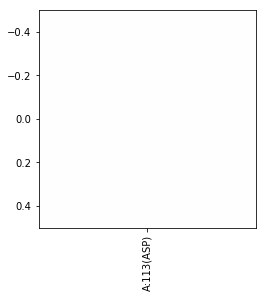

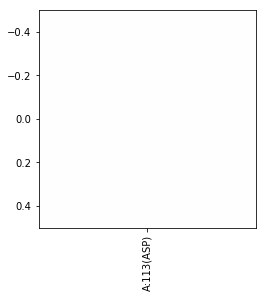

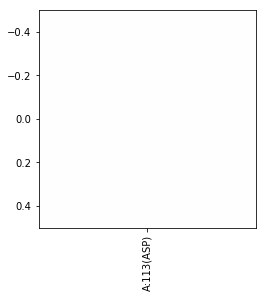

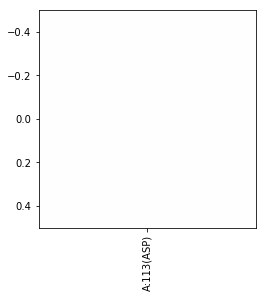

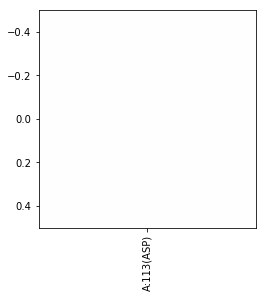

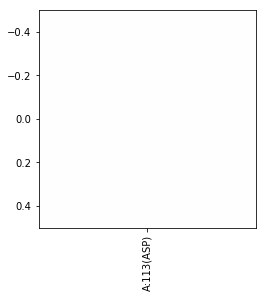

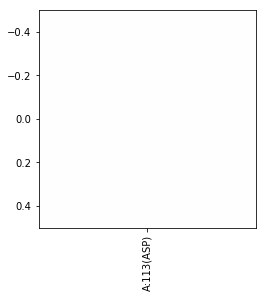

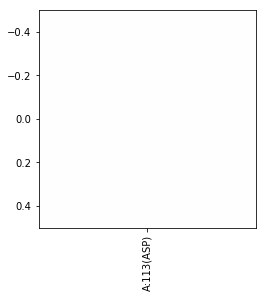

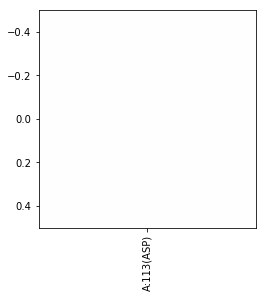

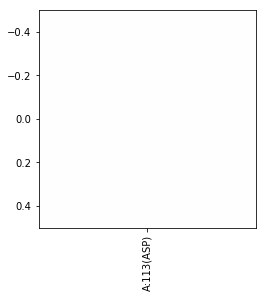

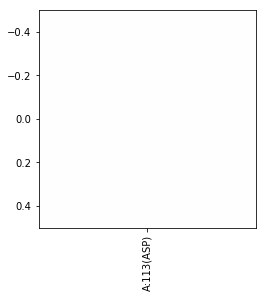

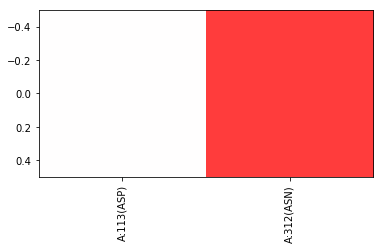

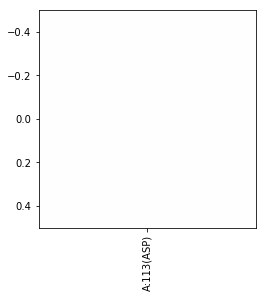

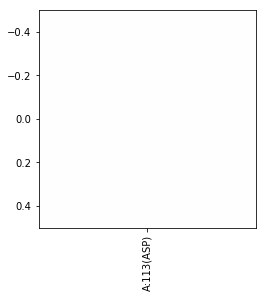

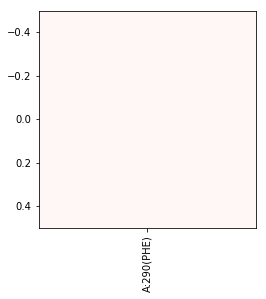

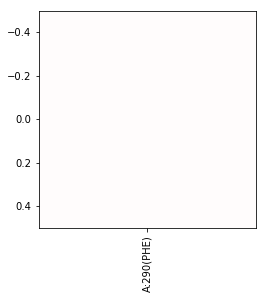

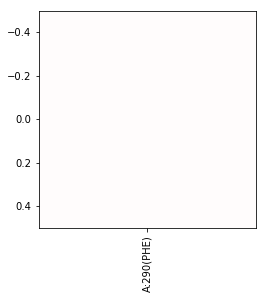

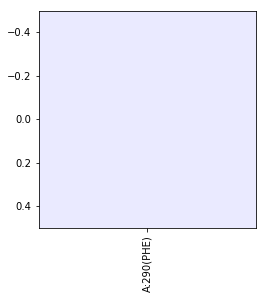

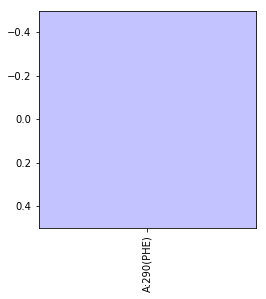

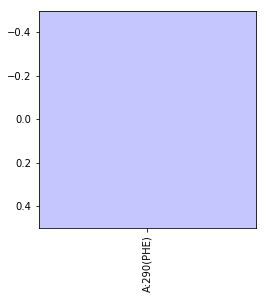

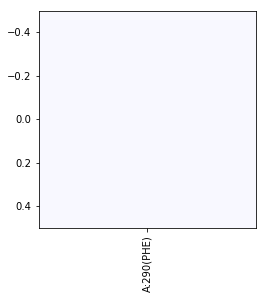

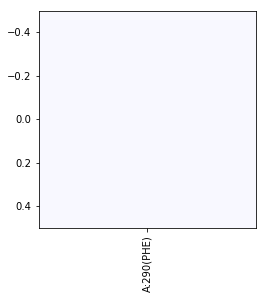

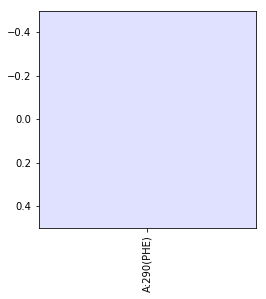

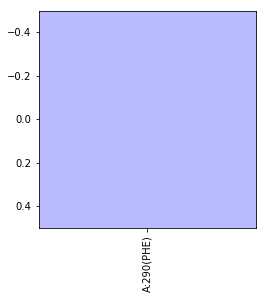

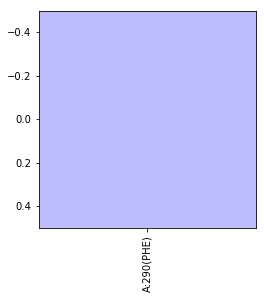

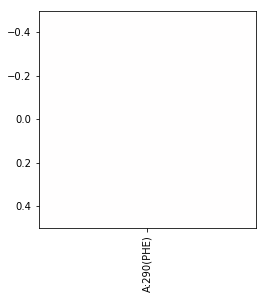

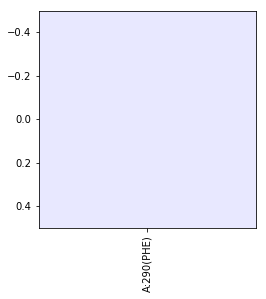

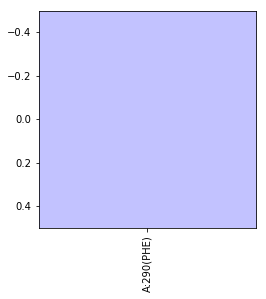

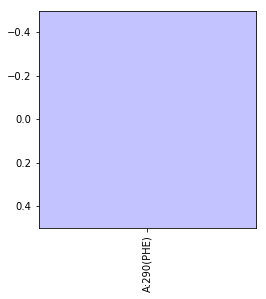

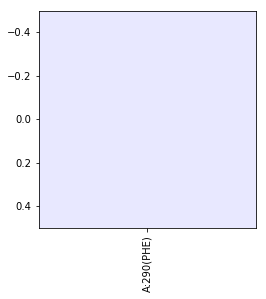

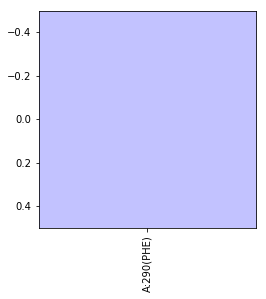

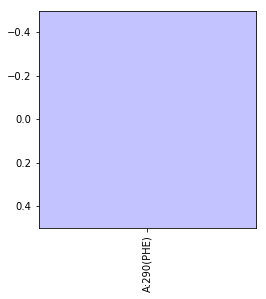

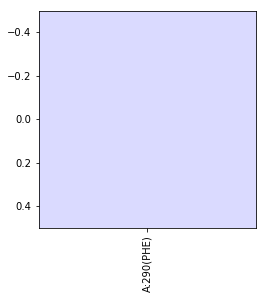

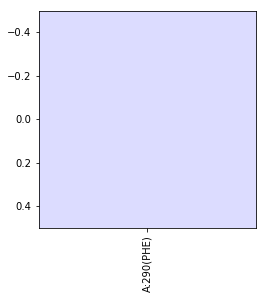

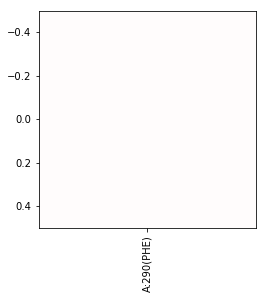

In [87]:
for feature in ps.k_list:
    if feature == 'mcss': continue
    for i, ligand1 in enumerate(l_list):
        for ligand2 in l_list[i+1:]:
            norm, scores1 = residue_features(poses1, cluster1, ps, feature, ligand1, ligand2)
            X = [[]]
            for res, (s1, s2) in scores.items():
                X[-1] += [s2 - s1]
            plt.imshow(X, cmap = 'bwr', vmin=-1, vmax = 1)
            plt.xticks(range(len(scores)), scores.keys(), rotation = 'vertical')
            plt.show()